In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "True"


In [52]:
from functools import partial

In [51]:
from scipy.stats import lognorm, skewnorm, norm
import numpy as np 

In [2]:
from bpd.io import load_dataset
import matplotlib.pyplot as plt 
import numpy as np 

In [75]:
import jax 
from jax import random, jit
import jax.numpy as jnp

In [88]:
from bpd.pipelines import pipeline_shear_inference, shear_loglikelihood
from bpd.prior import (
    interim_gprops_logprior,
    true_all_params_skew_logprior,
)
from bpd.chains import run_inference_nuts
from jax.scipy import stats

# Load dataset

In [3]:
# use random uniform value centered around truth

In [4]:
fpath = "/pscratch/sd/i/imendoza/data/cache_chains/exp23_43/full_samples_43.npz"

In [5]:
ds = load_dataset(fpath)

In [6]:
ds.keys()

dict_keys(['hyper', 'samples', 'truth'])

In [7]:
ds['samples']['lf'].shape

(10000, 4, 500)

# Check flux samples 

In [8]:
lf = ds['samples']['lf']
lf.shape

(10000, 4, 500)

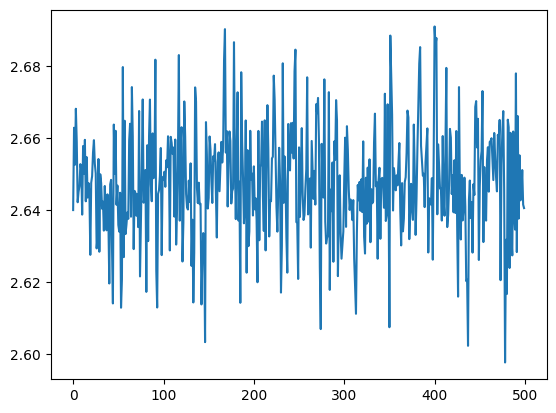

In [13]:
plt.plot(lf[111, 0, :])

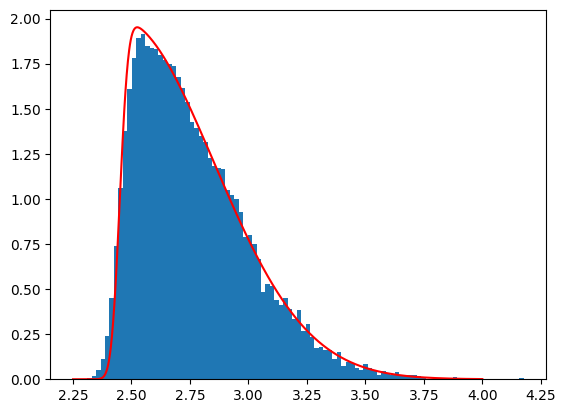

In [22]:
_ = plt.hist(lf.ravel(), bins=101, density=True)

x = np.linspace(2.25, 4.0, 1000)
y = skewnorm.pdf(x, a=14, loc=2.45, scale=0.4)

plt.plot(x, y, 'r-')

# Other samples ok? 

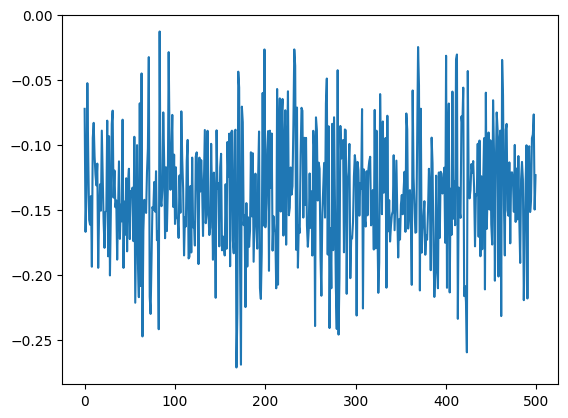

In [39]:
plt.plot(ds['samples']['e1'][0, 0, :])

# Shear inference

In [58]:
seed = 932
key = random.key(seed)

In [26]:
# only one chain out of 4 
ds2 = {k:v[:, 0, :] for k,v in ds['samples'].items()}

In [27]:
ds2.keys()

dict_keys(['dy', 'e2', 'e1', 'dx', 'lf', 'lhlr'])

In [28]:
ds2['e1'].shape

(10000, 500)

In [40]:
# setup pipeline
post_params = {
    "lf": ds2["lf"],
    "lhlr": ds2["lhlr"],
    "e1": ds2["e1"],
    "e2": ds2["e2"],
}

In [45]:
hyper = ds["hyper"]
sigma_e_int = hyper["sigma_e_int"]
sigma_e = hyper["sigma_e"]
mean_logflux = hyper["mean_logflux"]
sigma_logflux = hyper["sigma_logflux"]
a_logflux = 14
mean_loghlr = hyper["mean_loghlr"]
sigma_loghlr = hyper["sigma_loghlr"]

In [56]:
# setup priors
logprior_fnc = partial(
    true_all_params_skew_logprior,
    sigma_e=sigma_e,
    mean_logflux=mean_logflux,
    sigma_logflux=sigma_logflux,
    a_logflux=a_logflux,
    mean_loghlr=mean_loghlr,
    sigma_loghlr=sigma_loghlr,
)
interim_logprior_fnc = partial(
    interim_gprops_logprior,
    sigma_e=sigma_e_int,
    free_flux_hlr=True,
    free_dxdy=False,
)

In [63]:
g_samples = pipeline_shear_inference(
    key,
    post_params,
    init_g=jnp.array([0.0, 0.0]),
    logprior=logprior_fnc,
    interim_logprior=interim_logprior_fnc,
    n_samples=1000,
    initial_step_size=0.01,
)

In [64]:
g_samples.shape

(1000, 2)

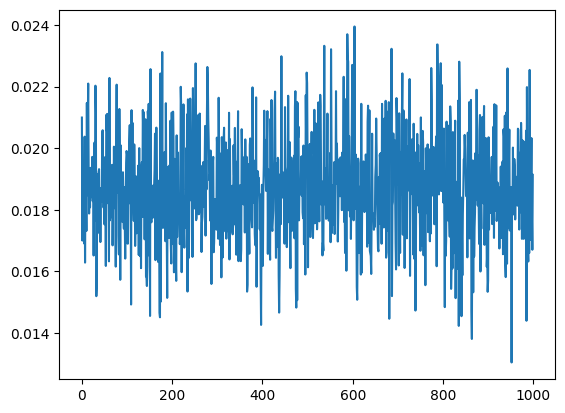

In [65]:
plt.plot(g_samples[:, 0])

In [95]:
g_samples[:, 0].std()

Array(0.00176582, dtype=float64)

# Inferring all parameters alongside shear

In [79]:
from bpd.utils import uniform_logpdf

def logtarget(
    params,
    *,
    data,
    sigma_e_int: float,
):
    g = params["g"]
    sigma_e = params["sigma_e"]
    mean_logflux = params["mean_logflux"]
    sigma_logflux = params["sigma_logflux"]
    mean_loghlr = params["mean_loghlr"]
    sigma_loghlr = params["sigma_loghlr"]
    a_logflux = params['a_logflux']

    # ignores dx,dy
    _logprior = partial(
        true_all_params_skew_logprior,
        sigma_e=sigma_e,
        mean_logflux=mean_logflux,
        sigma_logflux=sigma_logflux,
        a_logflux=a_logflux,
        mean_loghlr=mean_loghlr,
        sigma_loghlr=sigma_loghlr,
    )
    _interim_logprior = partial(
        interim_gprops_logprior,
        sigma_e=sigma_e_int,
        free_flux_hlr=True,
        free_dxdy=False,
    )
    loglike = shear_loglikelihood(
        g, post_params=data, logprior=_logprior, interim_logprior=_interim_logprior
    )
    g_mag = jnp.sqrt(g[0] ** 2 + g[1] ** 2)
    logprior_g = stats.uniform.logpdf(g_mag, 0.0, 1.0) + jnp.log(1 / (2 * jnp.pi))

    # uninformative
    logprior1 = uniform_logpdf(sigma_e, 1e-4, 0.5)
    logprior2 = uniform_logpdf(mean_logflux, -2.0, 6.0)
    logprior3 = uniform_logpdf(sigma_logflux, 0.0, 2.0)
    logprior6 = uniform_logpdf(a_logflux, -100, 100)
    logprior4 = uniform_logpdf(mean_loghlr, -2.0, 2.0)
    logprior5 = uniform_logpdf(sigma_loghlr, 0.0, 0.5)
    logprior = logprior1 + logprior2 + logprior3 + logprior4 + logprior5 + logprior_g

    return logprior + loglike


In [80]:
k1, k2 = random.split(key)

In [81]:
sigma_e_int = ds["hyper"]["sigma_e_int"]
true_sigma_e = ds["hyper"]["sigma_e"]
true_mean_logflux = ds["hyper"]["mean_logflux"]
true_sigma_logflux = ds["hyper"]["sigma_logflux"]
true_mean_loghlr = ds["hyper"]["mean_loghlr"]
true_sigma_loghlr = ds["hyper"]["sigma_loghlr"]
true_a_logflux = 14.0

_logtarget = jit(partial(logtarget, sigma_e_int=sigma_e_int))


# initialize positions randomly uniform from true parameters
k1s = random.split(k1, 6)
init_positions = {
    "g": jnp.zeros(2),
    "sigma_e": random.uniform(
        k1s[0], shape=(), minval=true_sigma_e - 0.02, maxval=true_sigma_e + 0.02
    ),
    "mean_logflux": random.uniform(
        k1s[1],
        shape=(),
        minval=true_mean_logflux - 0.25,
        maxval=true_mean_logflux + 0.25,
    ),
    "sigma_logflux": random.uniform(
        k1s[2],
        shape=(),
        minval=true_sigma_logflux - 0.04,
        maxval=true_sigma_logflux + 0.04,
    ),
    "a_logflux": random.uniform(
        k1s[2],
        shape=(),
        minval=true_a_logflux - 2,
        maxval=true_a_logflux + 2,
    ),
    "mean_loghlr": random.uniform(
        k1s[3],
        shape=(),
        minval=true_mean_loghlr - 0.04,
        maxval=true_mean_loghlr + 0.04,
    ),
    "sigma_loghlr": random.uniform(
        k1s[4],
        shape=(),
        minval=true_sigma_loghlr - 0.005,
        maxval=true_sigma_loghlr + 0.005,
    ),
}

In [83]:
init_positions

{'g': Array([0., 0.], dtype=float64),
 'sigma_e': Array(0.19994613, dtype=float64),
 'mean_logflux': Array(2.25693609, dtype=float64),
 'sigma_logflux': Array(0.39653165, dtype=float64),
 'a_logflux': Array(13.82658266, dtype=float64),
 'mean_loghlr': Array(-0.41478328, dtype=float64),
 'sigma_loghlr': Array(0.05401504, dtype=float64)}

In [89]:
post_params.keys()

dict_keys(['lf', 'lhlr', 'e1', 'e2'])

In [90]:
samples = run_inference_nuts(
    k2,
    data=post_params,
    init_positions=init_positions,
    logtarget=_logtarget,
    n_samples=1000,
    initial_step_size=0.01,
    max_num_doublings=5,
    n_warmup_steps=1000,
)

In [91]:
samples.keys()

dict_keys(['a_logflux', 'g', 'mean_logflux', 'mean_loghlr', 'sigma_e', 'sigma_logflux', 'sigma_loghlr'])

In [92]:
samples['g'].shape

(1000, 2)

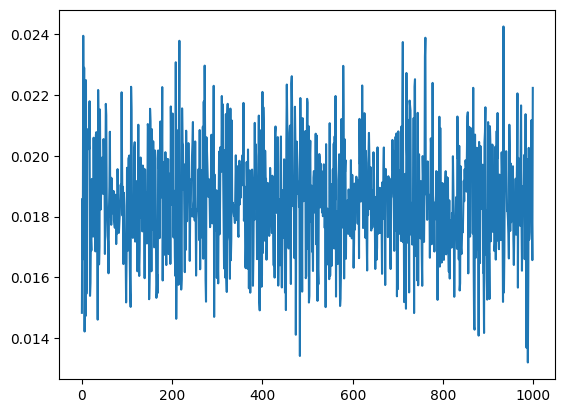

In [93]:
plt.plot(samples['g'][:, 0])

In [94]:
samples['g'][:, 0].std()

Array(0.00179184, dtype=float64)

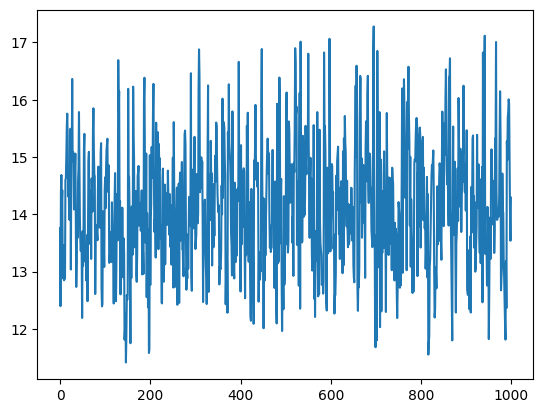

In [96]:
plt.plot(samples['a_logflux'])

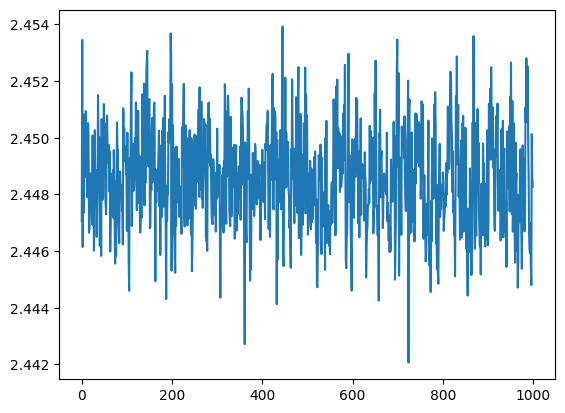

In [97]:
plt.plot(samples['mean_logflux'])

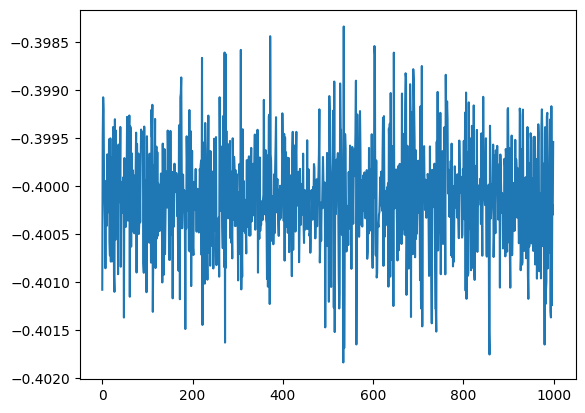

In [98]:
plt.plot(samples['mean_loghlr'])

In [99]:
from bpd.diagnostics import get_contour_plot

In [100]:
_samples = {**samples} 
_g = _samples.pop('g')
_samples['g1'] = _g[:, 0]
_samples['g2'] = _g[:, 1]

Parameter mean_loghlr in chain post1 is not constrained
Parameter g2 in chain post1 is not constrained


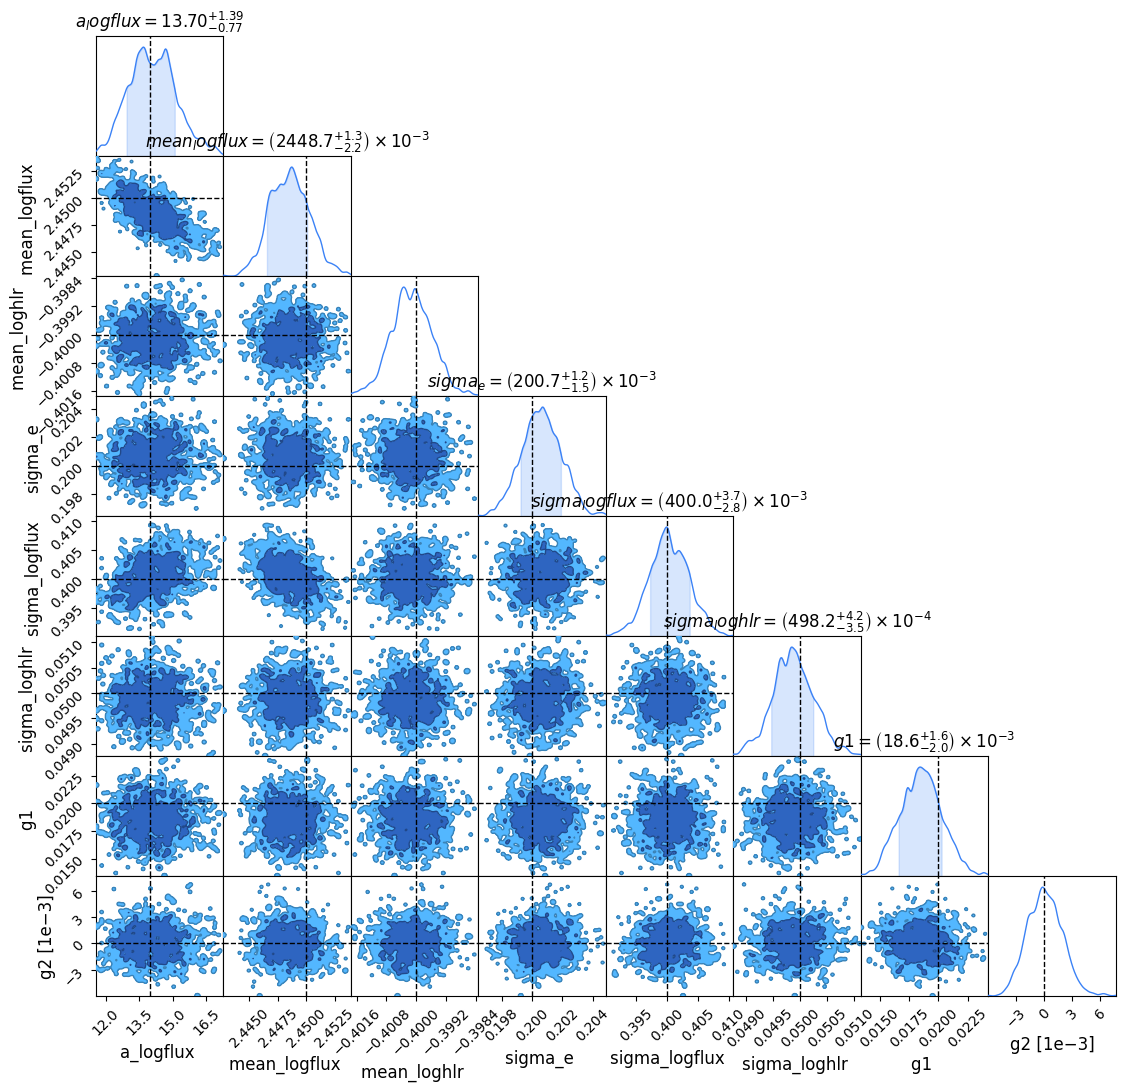

In [105]:
get_contour_plot([_samples], ['post1'], {'g1':0.02, 'g2':0.0, 'sigma_e': true_sigma_e, 
                                         'mean_logflux': true_mean_logflux, 'sigma_logflux': true_sigma_logflux, 'a_logflux': true_a_logflux,
                                         'mean_loghlr': true_mean_loghlr, 'sigma_loghlr': true_sigma_loghlr}, figsize=(12, 12));